In [14]:
!pip install numpy
!pip install pandas
!pip install torch
!pip install torch.nn
!pip install torch.optim
!pip install matplotlib
!pip install pyspectra
!pip install PyWavelets
!pip install Seaborn
!pip install scikit-learn



ERROR: Could not find a version that satisfies the requirement torch.nn (from versions: none)
ERROR: No matching distribution found for torch.nn


In [ ]:
# seg1
# 定义数据增强函数
def augment_data(spectrum, noise_level=0.01):
    """
    对光谱数据添加高斯噪声进行数据增强。
    spectrum: numpy array, shape: (2, seq_len)
    """
    noisy_spectrum = spectrum.copy()
    # 仅对强度通道添加噪声（索引为1）
    noise = np.random.normal(0, noise_level, size=noisy_spectrum[1].shape)
    noisy_spectrum[1] += noise
    return noisy_spectrum

In [ ]:
# seg2
# 导入必要的模块
import os
import re
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 导入读取 .spc 文件的函数
from pyspectra.readers.read_spc import read_spc

# 导入小波变换库
import pywt

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据路径和处理
data_dirs = [
    'remix_data',
    'remix_data_2',
    'remix_data_3'
    # 可以添加更多的路径
]

# 定义光谱数据集类
class SpectrumDataset(Dataset):
    def __init__(self, file_list, max_length=4096, augment=False):
        self.file_list = file_list
        self.max_length = max_length
        self.augment = augment
        self.data = []
        self.labels = []
        self.process_data()

    def process_data(self):
        for file_path in self.file_list:
            # 读取 .spc 或 .asc 文件
            if file_path.endswith('.spc'):
                spectrum = read_spc(file_path)
                wavelengths = spectrum.index.values
                intensities = spectrum.values.flatten()
            elif file_path.endswith('.asc'):
                data = pd.read_csv(file_path, sep='\t', header=None)
                wavelengths = data[0].values
                intensities = data[1].values

            # 插值到固定长度
            x_new = np.linspace(wavelengths.min(), wavelengths.max(), self.max_length)
            interpolated_intensities = np.interp(
                x_new,
                wavelengths,
                intensities
            )

            # 强度归一化到 [0, 1]
            normalized_intensities = (interpolated_intensities - interpolated_intensities.min()) / \
                                     (interpolated_intensities.max() - interpolated_intensities.min())

            # 波长归一化到 [0, 1]
            normalized_wavelengths = (x_new - x_new.min()) / (x_new.max() - x_new.min())

            # 组合波长和强度，形状为 (2, max_length)
            sample = np.stack([normalized_wavelengths, normalized_intensities], axis=0)

            # 数据增强
            if self.augment:
                sample = augment_data(sample)

            # 解析标签
            label = self.parse_label(os.path.basename(file_path))

            # 将处理后的数据和标签添加到列表
            self.data.append(sample)
            self.labels.append(label)

        # 将数据转换为 NumPy 数组
        self.data = np.array(self.data)  # shape: (num_samples, 2, max_length)
        self.labels = np.array(self.labels)

    def parse_label(self, filename):
        # 从文件名中提取成分和比例，兼容数字和罗马数字格式
        # 示例文件名: "III+IV(1比1)-1300-1s10a-10%-4.asc"
        # 或 "1+4(33%比66%)-1s10a-10%-6.spc"

        # 定义罗马数字与整数的对应关系
        roman_to_int = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
        # 合并罗马数字和阿拉伯数字的正则表达式
        components_match = re.search(r'([IVX]+\+?[IVX]*|\d+\+?\d*)\((.*?)\)', filename)
        if components_match:
            components_str = components_match.group(1)
            ratios_str = components_match.group(2)

            # 处理成分
            components = components_str.split('+')
            parsed_components = []
            for comp in components:
                comp = comp.strip()
                if comp.isdigit():
                    parsed_components.append(int(comp))
                elif comp in roman_to_int:
                    parsed_components.append(roman_to_int[comp])
                else:
                    #print(f"未知的成分格式：{comp}")
                    parsed_components.append(0)

            # 处理比例
            ratios = ratios_str.split('比')
            ratios = [r.strip('%') for r in ratios]
            ratios = [float(r) if r else 0 for r in ratios]

            # 如果比例中包含百分比，转换为实际比例
            if any('%' in ratios_str for r in ratios_str.split('比')):
                ratios = [r / 100 for r in ratios]
            else:
                total_ratio = sum(ratios)
                if total_ratio != 0:
                    ratios = [r / total_ratio for r in ratios]
                else:
                    ratios = [0 for r in ratios]
        else:
            # 如果无法匹配，返回零向量
            parsed_components = []
            ratios = []

        # 建立标签向量，四个苏丹红成分
        label = np.zeros(4)
        for comp, ratio in zip(parsed_components, ratios):
            if 1 <= comp <= 4:
                index = comp - 1  # 成分编号从 1 开始
                label[index] = ratio
            else:
                #print(f"未知的成分编号：{comp}")
                continue
                

        # 确保比例总和为 1
        if label.sum() != 0:
            label = label / label.sum()

        return label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spectrum = self.data[idx]  # shape: (2, max_length)
        label = self.labels[idx]
        return torch.tensor(spectrum, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)




In [ ]:
#seg3
# 收集所有路径中的文件
file_list = []
for data_dir in data_dirs:
    file_list.extend(glob.glob(os.path.join(data_dir, '*.spc')))
    file_list.extend(glob.glob(os.path.join(data_dir, '*.asc')))

# 載入數據集
dataset = SpectrumDataset(file_list, max_length=4096, augment=False)

# 檢查數據大小
print(f"✅ 數據集大小: {len(dataset)} 筆數據")

# 讀取第一筆數據
spectrum, label = dataset[0]

print("📊 第一筆數據 (spectrum) 形狀:", spectrum.shape)  # 應該是 (2, 4096)
print("🛠️ 第一筆數據 (label):", label)  # 這是該樣本的標籤

gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)


gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)


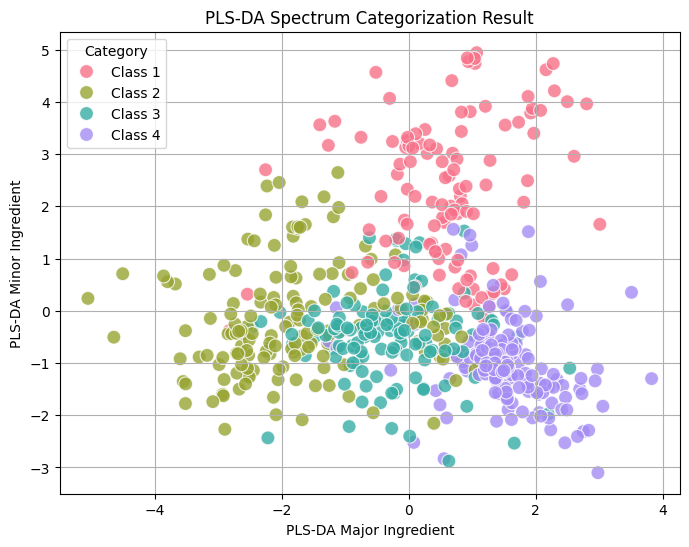

PLS-DA 測試集分類準確度: 0.86
PLS-DA 交叉驗證最佳準確度: 0.80


In [ ]:
# seg4
# PLS-DA + Cross Validation
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

# ✅ 假設 SpectrumDataset 已經正確加載
dataset = SpectrumDataset(file_list, max_length=4096, augment=False)

# -------------------------------
# 🛠️ Step 1: 提取光譜數據與標籤
# -------------------------------
X = np.array([sample[0].numpy().flatten() for sample in dataset])  # shape: (num_samples, num_features)
y = np.array([sample[1].numpy() for sample in dataset])  # shape: (num_samples, num_classes)

# 確保 y 轉換為數字標籤
y_numeric = np.argmax(y, axis=1)  # shape: (num_samples,)

# 確認數據形狀
print(f"✅ X shape (應該是 2D): {X.shape}")  # (num_samples, num_features)
print(f"✅ y shape (應該是 1D): {y_numeric.shape}")  # (num_samples,)

# -------------------------------
# 🔄 Step 2: 標準化數據
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # 確保數據均值為 0，標準差為 1

# -------------------------------
# 🔄 Step 3: 交叉驗證選擇最佳 PLS 主成分數
# -------------------------------
best_score = 0
best_n_components = 0
cv_scores = []

# PLS 成分數不能超過特徵數
max_components = min(15, X.shape[1])

# 使用 5-Fold Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n in range(2, max_components):  # 測試 n_components 從 2 到 max_components
    pls = PLSRegression(n_components=n)
    
    # 訓練 PLS 並確保 X_scores 是 2D
    X_scores = pls.fit_transform(X_scaled, y)[0]  # 取第一個輸出，確保是 2D
    print(f"PLS components {n}: X_scores shape {X_scores.shape}")  # Debugging

    # 交叉驗證
    scores = cross_val_score(LDA(), X_scores, y_numeric, cv=skf, scoring="accuracy")
    avg_score = scores.mean()
    cv_scores.append((n, avg_score))

    print(f"PLS components: {n}, CV Accuracy: {avg_score:.2f}")

    if avg_score > best_score:
        best_score = avg_score
        best_n_components = n

print(f"✅ 最佳 PLS 主成分數: {best_n_components}, 交叉驗證準確度: {best_score:.2f}")

# -------------------------------
# 🔢 Step 4: 使用最佳 PLS 訓練 PLS-DA
# -------------------------------
pls = PLSRegression(n_components=best_n_components)
pls.fit(X_scaled, y)  # y 是 one-hot 標籤矩陣

# 投影到 PLS 潛在變數空間
X_scores = pls.x_scores_

# -------------------------------
# 🔍 Step 5: LDA 在 PLS 分數空間中分類
# -------------------------------
lda = LDA()
X_lda = lda.fit_transform(X_scores, y_numeric)

# 🔄 修改標籤，使類別從 1 開始
y_numeric_plot = y_numeric + 1  # 讓標籤從 1 開始，而非 0

# 🔹 選擇合適的調色盤
num_classes = len(np.unique(y_numeric_plot))
palette = sns.color_palette("husl", num_classes)  # 自動生成不同顏色

# -------------------------------
# 📊 Step 6: 可視化 PLS-DA 結果
# -------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=y_numeric_plot, palette=palette, s=100, alpha=0.8)
plt.xlabel("PLS-DA Major Ingredient")
plt.ylabel("PLS-DA Minor Ingredient")
plt.title("PLS-DA Spectrum Categorization Result")

# 🔹 確保圖例顯示 Class 1, Class 2, ...
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [f"Class {int(l)}" for l in labels]
plt.legend(handles=handles, labels=new_labels, title="Category")

plt.grid(True)
plt.show()

# -------------------------------
# 🏆 Step 7: 訓練-測試集劃分，評估分類準確度
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_lda, y_numeric, test_size=0.2, random_state=42)

# 訓練 LDA 分類器
lda_classifier = LDA()
lda_classifier.fit(X_train, y_train)
y_pred = lda_classifier.predict(X_test)

# 計算分類準確度
test_accuracy = accuracy_score(y_test, y_pred)
print(f"PLS-DA 測試集分類準確度: {test_accuracy:.2f}")
print(f"PLS-DA 交叉驗證最佳準確度: {best_score:.2f}")



In [ ]:
# seg5
# PLS-DA + Cross Validation + VIP + 用VIP看能不能效果更好 用在不同批次
import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Data directories
data_dirs = [
    "remix_data",
    "remix_data_2",
    "remix_data_3"
]

# ✅ Store results
results_before_vip = []
results_after_vip = []

# ✅ Function to compute VIP scores
def calculate_vip(pls):
    """ Compute Variable Importance in Projection (VIP) scores """
    T = pls.x_scores_
    W = pls.x_weights_
    Q = pls.y_loadings_
    p, h = W.shape
    vip_scores = np.zeros(p)
    
    for i in range(p):
        weight_sum = np.sum(W[i, :] ** 2)
        vip_scores[i] = np.sqrt(p * np.sum((T @ Q.T) ** 2 * weight_sum) / np.sum((T @ Q.T) ** 2))

    return vip_scores

# ✅ Perform cross-testing (each directory is tested once)
for test_dir in data_dirs:
    print(f"\n🚀 Testing set from: {test_dir}")

    # Separate training & testing sets
    train_dirs = [d for d in data_dirs if d != test_dir]
    train_files = []
    test_files = glob.glob(os.path.join(test_dir, "*.*"))

    for train_dir in train_dirs:
        train_files.extend(glob.glob(os.path.join(train_dir, "*.*")))

    # ✅ Load dataset
    train_dataset = SpectrumDataset(train_files, max_length=4096, augment=False)
    test_dataset = SpectrumDataset(test_files, max_length=4096, augment=False)

    print(f"✅ Training set size: {len(train_dataset)} samples")
    print(f"✅ Testing set size: {len(test_dataset)} samples")

    # ✅ Extract features & labels
    X_train = np.array([sample[0].numpy().flatten() for sample in train_dataset])
    y_train = np.array([sample[1].numpy() for sample in train_dataset])

    X_test = np.array([sample[0].numpy().flatten() for sample in test_dataset])
    y_test = np.array([sample[1].numpy() for sample in test_dataset])

    # ✅ Convert y to numeric labels
    y_train_numeric = np.argmax(y_train, axis=1)
    y_test_numeric = np.argmax(y_test, axis=1)

    # ✅ Standardize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # -------------------------------
    # 🔄 Step 1: Find the Best PLS Components
    # -------------------------------
    best_score = 0
    best_n_components = 0
    max_components = min(15, X_train.shape[1])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for n in range(2, max_components):
        pls = PLSRegression(n_components=n)
        X_train_scores = pls.fit_transform(X_train_scaled, y_train)[0]

        # Cross-validation accuracy
        lda = LDA()
        scores = cross_val_score(lda, X_train_scores, y_train_numeric, cv=skf, scoring="accuracy")
        avg_score = scores.mean()

        if avg_score > best_score:
            best_score = avg_score
            best_n_components = n

    print(f"✅ Best PLS components: {best_n_components}, CV Accuracy: {best_score:.2f}")

    # -------------------------------
    # 🔢 Step 2: Train Initial PLS-DA Model (Before VIP Selection)
    # -------------------------------
    pls = PLSRegression(n_components=best_n_components)
    pls.fit(X_train_scaled, y_train)

    # Compute VIP scores
    vip_scores = calculate_vip(pls)

    # Project to PLS latent space
    X_train_scores = pls.transform(X_train_scaled)
    X_test_scores = pls.transform(X_test_scaled)

    # Train LDA classifier
    lda = LDA()
    X_train_lda = lda.fit_transform(X_train_scores, y_train_numeric)
    X_test_lda = lda.transform(X_test_scores)

    lda_classifier = LDA()
    lda_classifier.fit(X_train_lda, y_train_numeric)
    y_pred = lda_classifier.predict(X_test_lda)

    # Compute initial accuracy
    test_accuracy_before = accuracy_score(y_test_numeric, y_pred)
    results_before_vip.append((test_dir, test_accuracy_before))
    print(f"🎯 Initial Test Accuracy (Before VIP) [{test_dir}]: {test_accuracy_before:.2f}")

    # -------------------------------
    # 📊 Step 3: Select Features Using VIP (Only VIP > 9)
    # -------------------------------
    important_features = np.where(vip_scores > 4)[0]  # Select features with VIP > 1
    print(f"🔍 Selected {len(important_features)} important features out of {X_train.shape[1]}")

    X_train_vip = X_train_scaled[:, important_features]
    X_test_vip = X_test_scaled[:, important_features]

    # -------------------------------
    # 🔢 Step 4: Train Optimized PLS-DA Model (After VIP Selection)
    # -------------------------------
    pls_vip = PLSRegression(n_components=min(best_n_components, len(important_features)))
    pls_vip.fit(X_train_vip, y_train)

    X_train_scores_vip = pls_vip.transform(X_train_vip)
    X_test_scores_vip = pls_vip.transform(X_test_vip)

    lda_vip = LDA()
    X_train_lda_vip = lda_vip.fit_transform(X_train_scores_vip, y_train_numeric)
    X_test_lda_vip = lda_vip.transform(X_test_scores_vip)

    lda_classifier_vip = LDA()
    lda_classifier_vip.fit(X_train_lda_vip, y_train_numeric)
    y_pred_vip = lda_classifier_vip.predict(X_test_lda_vip)

    # Compute optimized accuracy
    test_accuracy_after = accuracy_score(y_test_numeric, y_pred_vip)
    results_after_vip.append((test_dir, test_accuracy_after))
    print(f"🎯 Optimized Test Accuracy (After VIP) [{test_dir}]: {test_accuracy_after:.2f}")


# 🔥 Compute Average Accuracies
avg_before_vip = np.mean([res[1] for res in results_before_vip])
avg_after_vip = np.mean([res[1] for res in results_after_vip])

print("\n📊 Test Results Before VIP Selection:")
for test_dir, acc in results_before_vip:
    print(f"📂 Test Set: {test_dir} -> Accuracy: {acc:.2f}")

print("\n📊 Test Results After VIP Selection:")
for test_dir, acc in results_after_vip:
    print(f"📂 Test Set: {test_dir} -> Accuracy: {acc:.2f}")

print(f"\n✅ Average Test Accuracy Before VIP: {avg_before_vip:.2f}")
print(f"✅ Average Test Accuracy After VIP: {avg_after_vip:.2f}")



🚀 Testing set from: remix_data
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)


In [ ]:
# seg6
# PLS-DA + Cross Validation + VIP + Hamming Accuracy + batches

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# sys.stdout = open('output.txt', 'w')  # 把所有輸出寫入檔案

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Data directories
data_dirs = [
    "remix_data",
    "remix_data_2",
    "remix_data_3"
]

# ✅ Store results
results_before_vip = []
results_after_vip = []
hamming_results_before_vip = []
hamming_results_after_vip = []

# ✅ Function to compute VIP scores
def calculate_vip(pls):
    """ Compute Variable Importance in Projection (VIP) scores """
    T = pls.x_scores_
    W = pls.x_weights_
    Q = pls.y_loadings_
    p, h = W.shape
    vip_scores = np.zeros(p)
    
    for i in range(p):
        weight_sum = np.sum(W[i, :] ** 2)
        vip_scores[i] = np.sqrt(p * np.sum((T @ Q.T) ** 2 * weight_sum) / np.sum((T @ Q.T) ** 2))

    return vip_scores

def hamming_accuracy(y_true, y_pred):
    """ Compute Hamming Accuracy for multi-label classification """
    return 1 - np.mean(np.abs(y_true - y_pred))

# ✅ Perform cross-testing (each directory is tested once)
for test_dir in data_dirs:
    print(f"\n🚀 Testing set from: {test_dir}")

    # Separate training & testing sets
    train_dirs = [d for d in data_dirs if d != test_dir]
    train_files = []
    test_files = glob.glob(os.path.join(test_dir, "*.*"))

    for train_dir in train_dirs:
        train_files.extend(glob.glob(os.path.join(train_dir, "*.*")))

    # ✅ Load dataset
    train_dataset = SpectrumDataset(train_files, max_length=4096, augment=False)
    test_dataset = SpectrumDataset(test_files, max_length=4096, augment=False)

    print(f"✅ Training set size: {len(train_dataset)} samples")
    print(f"✅ Testing set size: {len(test_dataset)} samples")

    # ✅ Extract features & labels
    X_train = np.array([sample[0].numpy().flatten() for sample in train_dataset])
    y_train = np.array([sample[1].numpy() for sample in train_dataset])

    X_test = np.array([sample[0].numpy().flatten() for sample in test_dataset])
    y_test = np.array([sample[1].numpy() for sample in test_dataset])

    # ✅ Convert y to numeric labels
    y_train_numeric = np.argmax(y_train, axis=1)
    y_test_numeric = np.argmax(y_test, axis=1)

    # ✅ Standardize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # -------------------------------
    # 🔄 Step 1: Find the Best PLS Components
    # -------------------------------
    best_score = 0
    best_n_components = 0
    max_components = min(15, X_train.shape[1])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for n in range(2, max_components):
        pls = PLSRegression(n_components=n)
        X_train_scores = pls.fit_transform(X_train_scaled, y_train)[0]

        # Cross-validation accuracy
        lda = LDA()
        scores = cross_val_score(lda, X_train_scores, y_train_numeric, cv=skf, scoring="accuracy")
        avg_score = scores.mean()

        if avg_score > best_score:
            best_score = avg_score
            best_n_components = n

    print(f"✅ Best PLS components: {best_n_components}, CV Accuracy: {best_score:.2f}")

    # -------------------------------
    # 🔢 Step 2: Train Initial PLS-DA Model (Before VIP Selection)
    # -------------------------------
    pls = PLSRegression(n_components=best_n_components)
    pls.fit(X_train_scaled, y_train)

    # Compute VIP scores
    vip_scores = calculate_vip(pls)

    # Project to PLS latent space
    X_train_scores = pls.transform(X_train_scaled)
    X_test_scores = pls.transform(X_test_scaled)

    # Train LDA classifier
    lda = LDA()
    X_train_lda = lda.fit_transform(X_train_scores, y_train_numeric)
    X_test_lda = lda.transform(X_test_scores)

    lda_classifier = LDA()
    lda_classifier.fit(X_train_lda, y_train_numeric)
    y_pred = lda_classifier.predict(X_test_lda)

    # Compute initial accuracy
    test_accuracy_before = accuracy_score(y_test_numeric, y_pred)
    results_before_vip.append((test_dir, test_accuracy_before))
    print(f"🎯 Initial Test Accuracy (Before VIP) [{test_dir}]: {test_accuracy_before:.2f}")

    # ✅ Compute Initial Hamming Accuracy
    test_accuracy_hamming_before = hamming_accuracy(y_test, np.eye(y_test.shape[1])[y_pred])
    hamming_results_before_vip.append((test_dir, test_accuracy_hamming_before))
    print(f"🎯 Initial Hamming Accuracy [{test_dir}]: {test_accuracy_hamming_before:.2f}")

    # -------------------------------
    # 📊 Step 3: Select Features Using VIP (Only VIP > 3)
    # -------------------------------
    important_features = np.where(vip_scores > 4)[0]
    print(f"🔍 Selected {len(important_features)} important features out of {X_train.shape[1]}")

    X_train_vip = X_train_scaled[:, important_features]
    X_test_vip = X_test_scaled[:, important_features]

    # -------------------------------
    # 🔢 Step 4: Train Optimized PLS-DA Model (After VIP Selection)
    # -------------------------------
    pls_vip = PLSRegression(n_components=min(best_n_components, len(important_features)))
    pls_vip.fit(X_train_vip, y_train)

    X_train_scores_vip = pls_vip.transform(X_train_vip)
    X_test_scores_vip = pls_vip.transform(X_test_vip)

    lda_vip = LDA()
    X_train_lda_vip = lda_vip.fit_transform(X_train_scores_vip, y_train_numeric)
    X_test_lda_vip = lda_vip.transform(X_test_scores_vip)

    lda_classifier_vip = LDA()
    lda_classifier_vip.fit(X_train_lda_vip, y_train_numeric)
    y_pred_vip = lda_classifier_vip.predict(X_test_lda_vip)

    # Compute optimized accuracy
    test_accuracy_after = accuracy_score(y_test_numeric, y_pred_vip)
    results_after_vip.append((test_dir, test_accuracy_after))
    print(f"🎯 Optimized Test Accuracy (After VIP) [{test_dir}]: {test_accuracy_after:.2f}")

    # ✅ Compute Hamming Accuracy After VIP
    test_accuracy_hamming_after = hamming_accuracy(y_test, np.eye(y_test.shape[1])[y_pred_vip])
    hamming_results_after_vip.append((test_dir, test_accuracy_hamming_after))
    print(f"🎯 Optimized Hamming Accuracy [{test_dir}]: {test_accuracy_hamming_after:.2f}")

# 🔥 Compute Average Accuracies
avg_hamming_before_vip = np.mean([res[1] for res in hamming_results_before_vip])
avg_hamming_after_vip = np.mean([res[1] for res in hamming_results_after_vip])

print(f"\n✅ Average Hamming Accuracy Before VIP: {avg_hamming_before_vip:.2f}")
print(f"✅ Average Hamming Accuracy After VIP: {avg_hamming_after_vip:.2f}")

# sys.stdout.close()
# sys.stdout = sys.__stdout__  # 恢復正常輸出

# # 讀取檔案並完整顯示
# with open('output.txt', 'r') as f:
#     print(f.read())



🚀 Testing set from: remix_data
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)


In [ ]:
# seg7
# PLS-DA + Cross Validation + VIP + Hamming Accuracy + batches

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# sys.stdout = open('output.txt', 'w')  # 把所有輸出寫入檔案

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Data directories
data_dirs = [
    "remix_data",
    "remix_data_2",
    "remix_data_3"
]

# ✅ Store results
results_before_vip = []
results_after_vip = []
hamming_results_before_vip = []
hamming_results_after_vip = []

# ✅ Function to compute VIP scores
def calculate_vip(pls):
    """ Compute Variable Importance in Projection (VIP) scores """
    T = pls.x_scores_
    W = pls.x_weights_
    Q = pls.y_loadings_
    p, h = W.shape
    vip_scores = np.zeros(p)
    
    for i in range(p):
        weight_sum = np.sum(W[i, :] ** 2)
        vip_scores[i] = np.sqrt(p * np.sum((T @ Q.T) ** 2 * weight_sum) / np.sum((T @ Q.T) ** 2))

    return vip_scores

def hamming_accuracy(y_true, y_pred):
    """ Compute Hamming Accuracy for multi-label classification """
    return 1 - np.mean(np.abs(y_true - y_pred))

# ✅ Perform cross-testing (each directory is tested once)
for test_dir in data_dirs:
    print(f"\n🚀 Testing set from: {test_dir}")

    # Separate training & testing sets
    train_dirs = [d for d in data_dirs if d != test_dir]
    train_files = []
    test_files = glob.glob(os.path.join(test_dir, "*.*"))

    for train_dir in train_dirs:
        train_files.extend(glob.glob(os.path.join(train_dir, "*.*")))

    # ✅ Load dataset
    train_dataset = SpectrumDataset(train_files, max_length=4096, augment=False)
    test_dataset = SpectrumDataset(test_files, max_length=4096, augment=False)

    print(f"✅ Training set size: {len(train_dataset)} samples")
    print(f"✅ Testing set size: {len(test_dataset)} samples")

    # ✅ Extract features & labels
    X_train = np.array([sample[0].numpy().flatten() for sample in train_dataset])
    y_train = np.array([sample[1].numpy() for sample in train_dataset])

    X_test = np.array([sample[0].numpy().flatten() for sample in test_dataset])
    y_test = np.array([sample[1].numpy() for sample in test_dataset])

    # ✅ Convert y to numeric labels
    y_train_numeric = np.argmax(y_train, axis=1)
    y_test_numeric = np.argmax(y_test, axis=1)

    # ✅ Standardize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # -------------------------------
    # 🔄 Step 1: Find the Best PLS Components
    # -------------------------------
    best_score = 0
    best_n_components = 0
    max_components = min(15, X_train.shape[1])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for n in range(2, max_components):
        pls = PLSRegression(n_components=n)
        X_train_scores = pls.fit_transform(X_train_scaled, y_train)[0]

        # Cross-validation accuracy
        lda = LDA()
        scores = cross_val_score(lda, X_train_scores, y_train_numeric, cv=skf, scoring="accuracy")
        avg_score = scores.mean()

        if avg_score > best_score:
            best_score = avg_score
            best_n_components = n

    print(f"✅ Best PLS components: {best_n_components}, CV Accuracy: {best_score:.2f}")

    # -------------------------------
    # 🔢 Step 2: Train Initial PLS-DA Model (Before VIP Selection)
    # -------------------------------
    pls = PLSRegression(n_components=best_n_components)
    pls.fit(X_train_scaled, y_train)

    # Compute VIP scores
    vip_scores = calculate_vip(pls)

    # Project to PLS latent space
    X_train_scores = pls.transform(X_train_scaled)
    X_test_scores = pls.transform(X_test_scaled)

    # Train LDA classifier
    lda = LDA()
    X_train_lda = lda.fit_transform(X_train_scores, y_train_numeric)
    X_test_lda = lda.transform(X_test_scores)

    lda_classifier = LDA()
    lda_classifier.fit(X_train_lda, y_train_numeric)
    y_pred = lda_classifier.predict(X_test_lda)

    # Compute initial accuracy
    test_accuracy_before = accuracy_score(y_test_numeric, y_pred)
    results_before_vip.append((test_dir, test_accuracy_before))
    print(f"🎯 Initial Test Accuracy (Before VIP) [{test_dir}]: {test_accuracy_before:.2f}")

    # ✅ Compute Initial Hamming Accuracy
    test_accuracy_hamming_before = hamming_accuracy(y_test, np.eye(y_test.shape[1])[y_pred])
    hamming_results_before_vip.append((test_dir, test_accuracy_hamming_before))
    print(f"🎯 Initial Hamming Accuracy [{test_dir}]: {test_accuracy_hamming_before:.2f}")

    # -------------------------------
    # 📊 Step 3: Select Features Using VIP (Only VIP > 3)
    # -------------------------------
    important_features = np.where(vip_scores > 4)[0]
    print(f"🔍 Selected {len(important_features)} important features out of {X_train.shape[1]}")

    X_train_vip = X_train_scaled[:, important_features]
    X_test_vip = X_test_scaled[:, important_features]

    # -------------------------------
    # 🔢 Step 4: Train Optimized PLS-DA Model (After VIP Selection)
    # -------------------------------
    pls_vip = PLSRegression(n_components=min(best_n_components, len(important_features)))
    pls_vip.fit(X_train_vip, y_train)

    X_train_scores_vip = pls_vip.transform(X_train_vip)
    X_test_scores_vip = pls_vip.transform(X_test_vip)

    lda_vip = LDA()
    X_train_lda_vip = lda_vip.fit_transform(X_train_scores_vip, y_train_numeric)
    X_test_lda_vip = lda_vip.transform(X_test_scores_vip)

    lda_classifier_vip = LDA()
    lda_classifier_vip.fit(X_train_lda_vip, y_train_numeric)
    y_pred_vip = lda_classifier_vip.predict(X_test_lda_vip)

    # Compute optimized accuracy
    test_accuracy_after = accuracy_score(y_test_numeric, y_pred_vip)
    results_after_vip.append((test_dir, test_accuracy_after))
    print(f"🎯 Optimized Test Accuracy (After VIP) [{test_dir}]: {test_accuracy_after:.2f}")

    # ✅ Compute Hamming Accuracy After VIP
    test_accuracy_hamming_after = hamming_accuracy(y_test, np.eye(y_test.shape[1])[y_pred_vip])
    hamming_results_after_vip.append((test_dir, test_accuracy_hamming_after))
    print(f"🎯 Optimized Hamming Accuracy [{test_dir}]: {test_accuracy_hamming_after:.2f}")

# 🔥 Compute Average Accuracies
avg_hamming_before_vip = np.mean([res[1] for res in hamming_results_before_vip])
avg_hamming_after_vip = np.mean([res[1] for res in hamming_results_after_vip])

print(f"\n✅ Average Hamming Accuracy Before VIP: {avg_hamming_before_vip:.2f}")
print(f"✅ Average Hamming Accuracy After VIP: {avg_hamming_after_vip:.2f}")

# sys.stdout.close()
# sys.stdout = sys.__stdout__  # 恢復正常輸出

# # 讀取檔案並完整顯示
# with open('output.txt', 'r') as f:
#     print(f.read())


🚀 Testing set from: remix_data
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)


gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)
gx-y(1)


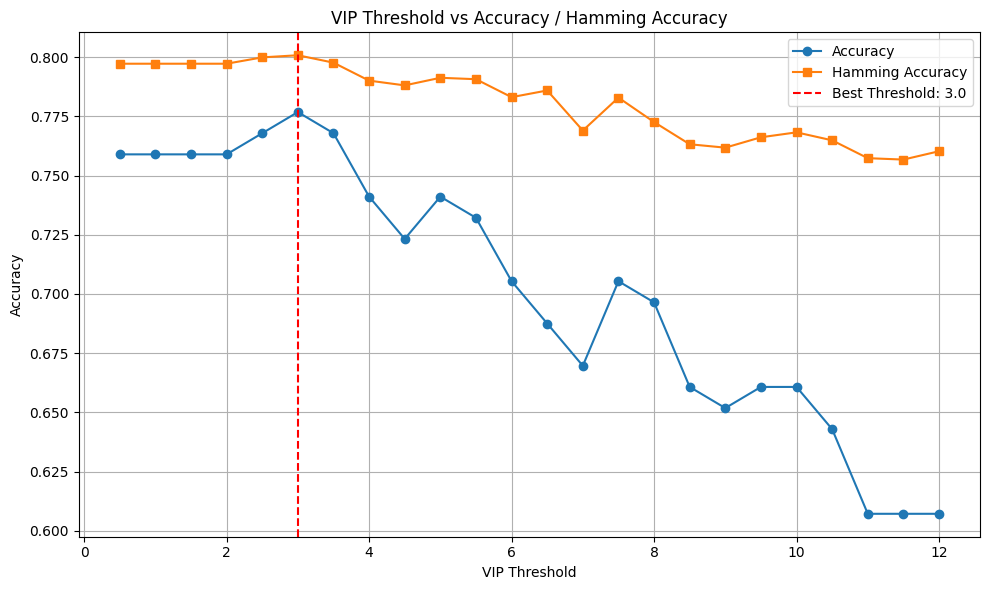

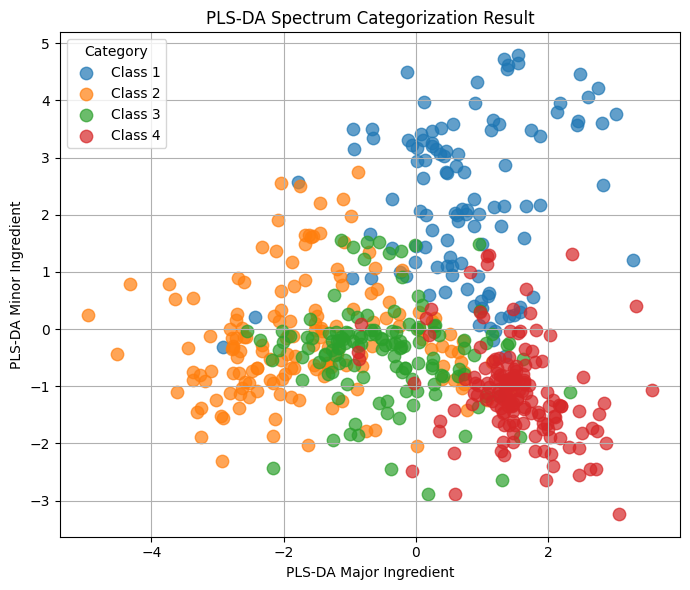

'\n# -------------------------------\n# 🧪 標記最佳特徵的波長位置\n# -------------------------------\nwavelength_features = best_features[best_features < 4096]\nintensity_features = best_features[best_features >= 4096] - 4096\n\nwavelengths = dataset[0][0][0].numpy()\n\nplt.figure(figsize=(14, 4))\nplt.plot(wavelengths, label=\'Normalized Wavelength\')\nplt.scatter(wavelengths[wavelength_features], np.ones(len(wavelength_features))*1.05, \n            color=\'blue\', label=\'Wavelength Features\', marker=\'|\', s=80)\nplt.scatter(wavelengths[intensity_features], np.ones(len(intensity_features))*0.95, \n            color=\'red\', label=\'Intensity Features\', marker=\'|\', s=80)\nplt.title(f"VIP Selected Features (Threshold = {best_threshold:.1f})")\nplt.xlabel("Normalized Wavelength")\nplt.ylabel("Marker")\nplt.ylim(0.9, 1.1)\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n'

In [ ]:
# seg8
import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split

# ✅ 輔助函式
def hamming_accuracy(y_true, y_pred):
    return 1 - np.mean(np.abs(y_true - y_pred))

def calculate_vip(pls):
    T = pls.x_scores_
    W = pls.x_weights_
    Q = pls.y_loadings_
    p, h = W.shape
    vip_scores = np.zeros(p)
    for i in range(p):
        weight_sum = np.sum(W[i, :] ** 2)
        vip_scores[i] = np.sqrt(p * np.sum((T @ Q.T)**2 * weight_sum) / np.sum((T @ Q.T)**2))
    return vip_scores

# ✅ 資料路徑
data_dirs = ['remix_data', 'remix_data_2', 'remix_data_3']
all_files = []
for d in data_dirs:
    all_files.extend(glob.glob(os.path.join(d, '*.*')))

# ✅ 載入資料
dataset = SpectrumDataset(all_files, max_length=4096, augment=False)

X = np.array([sample[0].numpy().flatten() for sample in dataset])
y = np.array([sample[1].numpy() for sample in dataset])
y_numeric = np.argmax(y, axis=1)

# ✅ Train/Test split
X_train, X_test, y_train, y_test, y_train_numeric, y_test_numeric = train_test_split(
    X, y, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

# ✅ 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ PLS 主成分選擇
best_score = 0
best_n_components = 0
max_components = min(15, X_train_scaled.shape[1])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n in range(2, max_components):
    pls = PLSRegression(n_components=n)
    X_scores = pls.fit_transform(X_train_scaled, y_train)[0]
    scores = []
    for train_idx, val_idx in skf.split(X_scores, y_train_numeric):
        lda = LDA()
        lda.fit(X_scores[train_idx], y_train_numeric[train_idx])
        val_pred = lda.predict(X_scores[val_idx])
        scores.append(accuracy_score(y_train_numeric[val_idx], val_pred))
    avg_score = np.mean(scores)
    if avg_score > best_score:
        best_score = avg_score
        best_n_components = n

print(f"✅ 最佳 PLS 主成分數: {best_n_components}, CV Accuracy: {best_score:.2f}")

# ✅ 訓練最終模型並計算 VIP 分數
pls = PLSRegression(n_components=best_n_components)
pls.fit(X_train_scaled, y_train)
vip_scores = calculate_vip(pls)

# ✅ VIP 門檻 Grid Search + 評估
threshold_range = np.arange(0.5, 12.5, 0.5)
acc_list = []
hamming_list = []
best_acc = 0
best_threshold = None
best_features = None

for threshold in threshold_range:
    important_features = np.where(vip_scores > threshold)[0]
    if len(important_features) < best_n_components:
        acc_list.append(np.nan)
        hamming_list.append(np.nan)
        continue

    # 選擇重要特徵後重新標準化
    X_train_vip = X_train_scaled[:, important_features]
    X_test_vip = X_test_scaled[:, important_features]
    scaler_vip = StandardScaler()
    X_train_vip = scaler_vip.fit_transform(X_train_vip)
    X_test_vip = scaler_vip.transform(X_test_vip)

    # PLS + LDA 訓練
    pls_vip = PLSRegression(n_components=best_n_components)
    pls_vip.fit(X_train_vip, y_train)
    X_train_scores_vip = pls_vip.transform(X_train_vip)
    X_test_scores_vip = pls_vip.transform(X_test_vip)

    lda_vip = LDA()
    lda_vip.fit(X_train_scores_vip, y_train_numeric)
    y_pred_vip = lda_vip.predict(X_test_scores_vip)

    acc = accuracy_score(y_test_numeric, y_pred_vip)
    hamm = hamming_accuracy(y_test, np.eye(y.shape[1])[y_pred_vip])
    acc_list.append(acc)
    hamming_list.append(hamm)

    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold
        best_features = important_features

print(f"\n🎯 最佳 VIP 門檻: {best_threshold:.1f}")
print(f"   Accuracy: {best_acc:.3f}")
print(f"   Hamming Accuracy: {hamming_list[np.argmax(acc_list)]:.3f}")
print(f"   Selected Features: {len(best_features)}")

# -------------------------------
# 📈 畫圖：VIP 門檻 vs Accuracy & Hamming Accuracy
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(threshold_range, acc_list, label='Accuracy', marker='o')
plt.plot(threshold_range, hamming_list, label='Hamming Accuracy', marker='s')
plt.axvline(best_threshold, linestyle='--', color='red', label=f'Best Threshold: {best_threshold:.1f}')
plt.xlabel("VIP Threshold")
plt.ylabel("Accuracy")
plt.title("VIP Threshold vs Accuracy / Hamming Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 📈 PLS-DA 2D Scatter Plot of Final Result
# -------------------------------
from matplotlib import cm

# 最佳模型投影後的資料點（以 VIP + LDA 為例）
X_all = np.vstack([X_train_scaled, X_test_scaled])
y_all_numeric = np.concatenate([y_train_numeric, y_test_numeric])

X_all_vip = X_all[:, best_features]
scaler_vip = StandardScaler()
X_all_vip = scaler_vip.fit_transform(X_all_vip)

pls_final = PLSRegression(n_components=best_n_components)
pls_final.fit(X_all_vip, np.vstack([y_train, y_test]))
X_all_scores = pls_final.transform(X_all_vip)

lda_final = LDA()
X_lda_final = lda_final.fit_transform(X_all_scores, y_all_numeric)

# -------------------------------
# 🌈 Plot
# -------------------------------
plt.figure(figsize=(7, 6))
num_classes = y.shape[1]
palette = sns.color_palette("husl", num_classes)

for class_idx in range(num_classes):
    indices = np.where(y_all_numeric == class_idx)[0]
    plt.scatter(X_lda_final[indices, 0],
                X_lda_final[indices, 1],
                label=f"Class {class_idx + 1}",
                alpha=0.7,
                s=80)

plt.xlabel("PLS-DA Major Ingredient")
plt.ylabel("PLS-DA Minor Ingredient")
plt.title("PLS-DA Spectrum Categorization Result")
plt.legend(title="Category")
plt.grid(True)
plt.tight_layout()
plt.show()


"""
# -------------------------------
# 🧪 標記最佳特徵的波長位置
# -------------------------------
wavelength_features = best_features[best_features < 4096]
intensity_features = best_features[best_features >= 4096] - 4096

wavelengths = dataset[0][0][0].numpy()

plt.figure(figsize=(14, 4))
plt.plot(wavelengths, label='Normalized Wavelength')
plt.scatter(wavelengths[wavelength_features], np.ones(len(wavelength_features))*1.05, 
            color='blue', label='Wavelength Features', marker='|', s=80)
plt.scatter(wavelengths[intensity_features], np.ones(len(intensity_features))*0.95, 
            color='red', label='Intensity Features', marker='|', s=80)
plt.title(f"VIP Selected Features (Threshold = {best_threshold:.1f})")
plt.xlabel("Normalized Wavelength")
plt.ylabel("Marker")
plt.ylim(0.9, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
"""


